In [1]:
!pip install --upgrade --force-reinstall pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2025.2
    Uninstalling tzdata-2025.2:
      Successfully uninstalled tzdata-2025.2
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six-1.

In [2]:
from google.colab import files
import zipfile
import os
import pandas as pd

# 1. zip 파일 업로드 받기
uploaded = files.upload()  # dataset.zip을 올려주세요!

# 2. 압축 해제
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")
print("✅ 압축 해제 완료!")

# 3. CSV 생성
DATASET_DIR = "dataset/dataset"
image_paths, object_types, material_types = [], [], []

for obj in os.listdir(DATASET_DIR):
    obj_path = os.path.join(DATASET_DIR, obj)

    if obj == 'cup':
        for material in os.listdir(obj_path):
            mat_path = os.path.join(obj_path, material)

            if os.path.isdir(mat_path):  # ✅ 폴더일 때만 탐색
                for fname in os.listdir(mat_path):
                    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                        image_paths.append(os.path.join(mat_path, fname))
                        object_types.append(obj)
                        material_types.append(material)

    elif obj == 'straw':
        for sub in os.listdir(obj_path):
            sub_path = os.path.join(obj_path, sub)

            if os.path.isdir(sub_path):  # ✅ 하위 폴더
                for fname in os.listdir(sub_path):
                    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                        image_paths.append(os.path.join(sub_path, fname))
                        object_types.append(obj)
                        material_types.append("plastic")
            elif sub.lower().endswith(('.jpg', '.jpeg', '.png')):  # ✅ 파일 바로 있는 경우
                image_paths.append(os.path.join(obj_path, sub))
                object_types.append(obj)
                material_types.append("plastic")

    elif obj == 'cupholder':
        for fname in os.listdir(obj_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(obj_path, fname))
                object_types.append(obj)
                material_types.append("paper")  # ✅ 고정

    elif obj == 'lid':
        for fname in os.listdir(obj_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(obj_path, fname))
                object_types.append(obj)
                material_types.append("plastic")  # ✅ 고정

# 4. CSV 생성 및 저장
df = pd.DataFrame({
    "image_path": image_paths,
    "object_type": object_types,
    "material_type": material_types
})
df.to_csv("labels.csv", index=False)
print("✅ labels.csv 생성 완료!")

# 5. 다운로드 (선택)
files.download("labels.csv")


Saving dataset.zip to dataset (1).zip
✅ 압축 해제 완료!
✅ labels.csv 생성 완료!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd

df = pd.read_csv("/content/labels.csv")  # 경로 주의

object_type_map = {'cup': 0, 'cupholder': 1, 'lid': 2, 'straw': 3}
material_type_map = {'paper': 0, 'plastic': 1}

df['object_label'] = df['object_type'].map(object_type_map)
df['material_label'] = df['material_type'].map(material_type_map)

print(df.head())


                        image_path object_type material_type  object_label  \
0  dataset/dataset/lid/lid_016.jpg         lid       plastic             2   
1  dataset/dataset/lid/lid_022.jpg         lid       plastic             2   
2  dataset/dataset/lid/lid_036.jpg         lid       plastic             2   
3  dataset/dataset/lid/lid_012.jpg         lid       plastic             2   
4  dataset/dataset/lid/lid_040.jpg         lid       plastic             2   

   material_label  
0               1  
1               1  
2               1  
3               1  
4               1  


In [4]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df[['object_label', 'material_label']]
)


tf.data.Dataset 만들기

In [5]:
import tensorflow as tf

IMG_SIZE = (180, 180)
BATCH_SIZE = 32

def preprocess(image_path, object_label, material_label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, {'object_output': object_label, 'material_output': material_label}

def create_dataset(dataframe, shuffle=True):
    paths = dataframe['image_path'].values
    obj_labels = dataframe['object_label'].values
    mat_labels = dataframe['material_label'].values

    dataset = tf.data.Dataset.from_tensor_slices((paths, obj_labels, mat_labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset(train_df)
val_ds = create_dataset(val_df, shuffle=False)


데이터 증강 레이어 (훈련용에만 적용)

In [6]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def augment(image, labels):
    return data_augmentation(image, training=True), labels

train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)


모델 구성 (MobileNetV2 + Multi-output)

In [7]:
from tensorflow.keras import models

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(180, 180, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(180, 180, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)

object_output = layers.Dense(4, activation='softmax', name='object_output')(x)
material_output = layers.Dense(2, activation='softmax', name='material_output')(x)

model = models.Model(inputs=inputs, outputs={'object_output': object_output, 'material_output': material_output})


/tmp/ipython-input-7-95944343.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


컴파일 & 학습

In [8]:
model.compile(
    optimizer='adam',
    loss={
        'object_output': 'sparse_categorical_crossentropy',
        'material_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'object_output': 'accuracy',
        'material_output': 'accuracy'
    }
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 1.8339 - material_output_accuracy: 0.6633 - material_output_loss: 0.6267 - object_output_accuracy: 0.4848 - object_output_loss: 1.1960 - val_loss: 0.2599 - val_material_output_accuracy: 1.0000 - val_material_output_loss: 0.0426 - val_object_output_accuracy: 0.9444 - val_object_output_loss: 0.2292
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.2124 - material_output_accuracy: 0.9932 - material_output_loss: 0.0397 - object_output_accuracy: 0.9486 - object_output_loss: 0.1716 - val_loss: 0.0468 - val_material_output_accuracy: 0.9815 - val_material_output_loss: 0.0284 - val_object_output_accuracy: 1.0000 - val_object_output_loss: 0.0234
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0484 - material_output_accuracy: 1.0000 - material_output_loss: 0.0169 - object_output_accuracy: 0.9951 - object_output_loss: 0.0310 - val_loss: 0.0196 - val_material_output_accuracy: 1.0000 - val_material_output_loss: 0.0120 - val_ob

In [9]:
model.save("/content/multilabel_model.keras")  # ✅ 권장 포맷
print("✅ 모델 저장 완료!")


✅ 모델 저장 완료!


In [10]:
OBJECT_CLASS_NAMES = ['cup', 'cupholder', 'lid', 'straw']
MATERIAL_CLASS_NAMES = ['paper', 'plastic']


In [11]:
from tensorflow.keras.preprocessing import image
import numpy as np
from pathlib import Path

def predict_image(img_path, threshold=0.6):
    if not Path(img_path).exists():
        print(f"❌ 파일을 찾을 수 없습니다: {img_path}")
        return

    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array / 255.0, axis=0)

    preds = model.predict(img_array)

    object_probs = preds['object_output'][0]
    material_probs = preds['material_output'][0]

    object_label = np.argmax(object_probs)
    material_label = np.argmax(material_probs)

    object_conf = object_probs[object_label]
    material_conf = material_probs[material_label]

    if object_conf < threshold:
        print(f"🧠 물체 예측: ❓ 예측 불가 (Conf: {object_conf:.2f})")
    else:
        print(f"🧠 물체 예측: {OBJECT_CLASS_NAMES[object_label]} ({object_conf*100:.2f}%)")

    if material_conf < threshold:
        print(f"🧪 재질 예측: ❓ 예측 불가 (Conf: {material_conf:.2f})")
    else:
        print(f"🧪 재질 예측: {MATERIAL_CLASS_NAMES[material_label]} ({material_conf*100:.2f}%)")




In [12]:
predict_image("/content/dataset/dataset/cup/paper/cup_paper_001.jpg")
predict_image("/content/dataset/dataset/lid/lid_001.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🧠 물체 예측: cup (100.00%)
🧪 재질 예측: paper (99.89%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
🧠 물체 예측: lid (100.00%)
🧪 재질 예측: plastic (100.00%)


In [13]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_and_show(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array / 255.0, axis=0)

    preds = model.predict(img_array)

    object_probs = preds['object_output'][0]
    material_probs = preds['material_output'][0]

    object_label = np.argmax(object_probs)
    material_label = np.argmax(material_probs)

    plt.imshow(img.astype("uint8"))
    plt.axis("off")
    plt.title(f"🧠 {OBJECT_CLASS_NAMES[object_label]} ({object_probs[object_label]*100:.1f}%)\n🧪 {MATERIAL_CLASS_NAMES[material_label]} ({material_probs[material_label]*100:.1f}%)")
    plt.show()


In [14]:
predict_image("/content/dataset/dataset/cup/paper/cup_paper_013.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
🧠 물체 예측: cup (100.00%)
🧪 재질 예측: paper (99.70%)


In [16]:
from sklearn.metrics import confusion_matrix, classification_report

# 예: object_output 예측
y_true = []
y_pred = []

for images, labels in val_ds.unbatch():
    pred = model.predict(tf.expand_dims(images, axis=0), verbose=0)
    obj_label = labels['object_output'].numpy()
    pred_label = np.argmax(pred['object_output'][0])
    y_true.append(obj_label)
    y_pred.append(pred_label)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=OBJECT_CLASS_NAMES))


[[14  0  0  0]
 [ 0 12  0  0]
 [ 0  0 12  0]
 [ 0  0  0 16]]
              precision    recall  f1-score   support

         cup       1.00      1.00      1.00        14
   cupholder       1.00      1.00      1.00        12
         lid       1.00      1.00      1.00        12
       straw       1.00      1.00      1.00        16

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



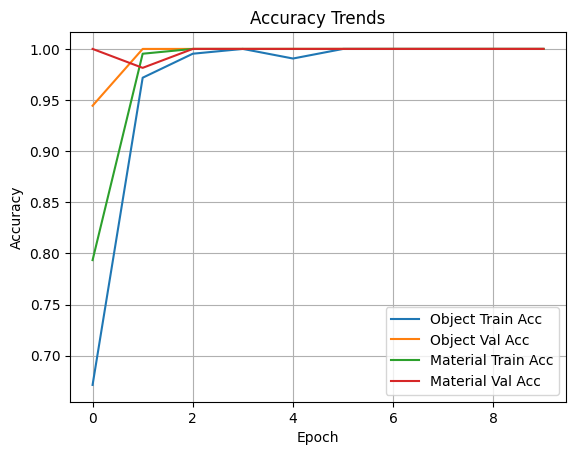

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['object_output_accuracy'], label='Object Train Acc')
plt.plot(history.history['val_object_output_accuracy'], label='Object Val Acc')
plt.plot(history.history['material_output_accuracy'], label='Material Train Acc')
plt.plot(history.history['val_material_output_accuracy'], label='Material Val Acc')
plt.title('Accuracy Trends')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()
